In [31]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [32]:
train_data = datasets.MNIST(
    root='data', 
    train=True, 
    transform=ToTensor(), 
    download=True
)
test_data = datasets.MNIST(
    root='data', 
    train=False, 
    transform=ToTensor(), 
    download=True
)

In [33]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),
    
    'test' : DataLoader(test_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1)    
}

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)

In [35]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)}({100. *batch_idx /len(loaders["train"]):.0f}%)]\t{loss.item():.6}')
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f})%\n')

In [36]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000(0%)]	2.3036
Train Epoch: 1 [2000/60000(3%)]	2.2899
Train Epoch: 1 [4000/60000(7%)]	2.17028
Train Epoch: 1 [6000/60000(10%)]	2.06081
Train Epoch: 1 [8000/60000(13%)]	1.96845
Train Epoch: 1 [10000/60000(17%)]	1.84686
Train Epoch: 1 [12000/60000(20%)]	1.79649
Train Epoch: 1 [14000/60000(23%)]	1.75874
Train Epoch: 1 [16000/60000(27%)]	1.75454
Train Epoch: 1 [18000/60000(30%)]	1.82857
Train Epoch: 1 [20000/60000(33%)]	1.69728
Train Epoch: 1 [22000/60000(37%)]	1.67847
Train Epoch: 1 [24000/60000(40%)]	1.69276
Train Epoch: 1 [26000/60000(43%)]	1.68507
Train Epoch: 1 [28000/60000(47%)]	1.64391
Train Epoch: 1 [30000/60000(50%)]	1.66787
Train Epoch: 1 [32000/60000(53%)]	1.61946
Train Epoch: 1 [34000/60000(57%)]	1.67573
Train Epoch: 1 [36000/60000(60%)]	1.68171
Train Epoch: 1 [38000/60000(63%)]	1.60745
Train Epoch: 1 [40000/60000(67%)]	1.63991
Train Epoch: 1 [42000/60000(70%)]	1.5978
Train Epoch: 1 [44000/60000(73%)]	1.63644
Train Epoch: 1 [46000/60000(77%)]	1.70684
Train 

Prediction: 7


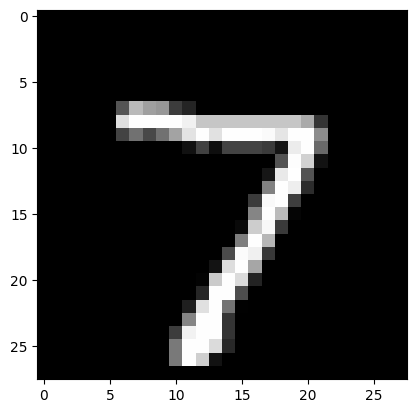

In [39]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim = True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()